<a href="https://colab.research.google.com/github/ashirwadsangwan/Tabular-Data-Projects/blob/master/ashrae_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashirwadsangwan","key":"a562fd00dd6ab5f6b556d2aeeab492e1"}'}

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Nov 12 12:21 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# List available competitions.
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2448            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14657           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5143            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         57           False  
tensorflow2-question-answering                 2020-01-22 23:59:00  Featured           $50,000        418           False  
data-science-bowl-2019                         2020-01-22 23:59:00  Featured          $160,000        791            True  
pku-auto

In [17]:

!kaggle competitions download -c ashrae-energy-prediction -p ~/.kaggle --force

  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 20.6MB/s]
 92% 81.0M/88.4M [00:01<00:00, 58.9MB/s]
100% 88.4M/88.4M [00:01<00:00, 82.9MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 86.1MB/s]
 84% 101M/120M [00:00<00:00, 156MB/s] 
100% 120M/120M [00:00<00:00, 204MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 170MB/s]
 92% 154M/167M [00:00<00:00, 202MB/s]
100% 167M/167M [00:00<00:00, 191MB/s]


In [0]:
import gc
import random
import math

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('~/.kaggle/competitions/ashrae-energy-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from warnings import filterwarnings as fw
fw("ignore")


path_data = "~/.kaggle/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

In [19]:
!unzip ~/.kaggle/weather_test.csv.zip -d ~/.kaggle
!unzip ~/.kaggle/weather_train.csv.zip -d ~/.kaggle
!unzip ~/.kaggle/test.csv.zip -d ~/.kaggle
!unzip ~/.kaggle/train.csv.zip -d ~/.kaggle
!unzip ~/.kaggle/sample_submission.csv.zip -d ~/.kaggle

Archive:  /root/.kaggle/weather_test.csv.zip
replace /root/.kaggle/weather_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /root/.kaggle/weather_test.csv  
Archive:  /root/.kaggle/weather_train.csv.zip
  inflating: /root/.kaggle/weather_train.csv  
Archive:  /root/.kaggle/test.csv.zip
  inflating: /root/.kaggle/test.csv  
Archive:  /root/.kaggle/train.csv.zip
  inflating: /root/.kaggle/train.csv  
Archive:  /root/.kaggle/sample_submission.csv.zip
  inflating: /root/.kaggle/sample_submission.csv  


In [20]:
!ls ~/.kaggle

building_metadata.csv	   test.csv	  weather_test.csv
kaggle.json		   test.csv.zip   weather_test.csv.zip
sample_submission.csv	   train.csv	  weather_train.csv
sample_submission.csv.zip  train.csv.zip  weather_train.csv.zip


In [0]:
!rm ~/.kaggle/sample_submission.csv.zip
!rm ~/.kaggle/train.csv.zip
!rm ~/.kaggle/weather_train.csv.zip
!rm ~/.kaggle/test.csv.zip
!rm ~/.kaggle/weather_test.csv.zip

In [22]:
gc.collect()

86

In [23]:
!ls ~/.kaggle/

building_metadata.csv  test.csv		 weather_train.csv
kaggle.json	       train.csv
sample_submission.csv  weather_test.csv


In [0]:
train_df = pd.read_csv(path_train)

building = pd.read_csv(path_building)
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

weather_train = pd.read_csv(path_weather_train)

In [0]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [26]:
train_df = reduce_mem_usage(train_df, use_float16=True)
building = reduce_mem_usage(building, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)
gc.collect()

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 74.9%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


0

In [0]:
def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    day_before_holiday = ["2016-01-17", "2016-02-14", "2016-05-29", "2016-07-03",
                "2016-09-04", "2016-10-09", "2016-11-10", "2016-11-23", "2016-12-25",
                "2016-12-31", "2017-01-15", "2017-02-19", "2017-05-28", "2017-07-03",
                "2017-09-03", "2017-10-08", "2017-11-09", "2017-11-22", "2017-12-24",
                "2017-12-31", "2018-01-14", "2018-02-18", "2018-05-27", "2018-07-03",
                "2018-09-02", "2018-10-07", "2018-11-11", "2018-11-21", "2018-12-24",
                "2018-12-31"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    X["is_day_before_holiday"] = (X.timestamp.dt.date.astype("str").isin(day_before_holiday)).astype(int)

    X['month_datetime'] = X['timestamp'].dt.month.astype(np.int8)
    X['weekofyear_datetime'] = X['timestamp'].dt.weekofyear.astype(np.int8)
    X['dayofyear_datetime'] = X['timestamp'].dt.dayofyear.astype(np.int16)

    X['hour_datetime'] = X['timestamp'].dt.hour.astype(np.int8)  
    X['day_week'] = X['timestamp'].dt.dayofweek.astype(np.int8)
    X['day_month_datetime'] = X['timestamp'].dt.day.astype(np.int8)
    X['week_month_datetime'] = X['timestamp'].dt.day/7
    X['week_month_datetime'] = X['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

    X['year_built'] = X['year_built']-1900
    X['square_feet'] = np.log(X['square_feet'])
    
    
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [28]:
X_train, y_train = prepare_data(train_df, building, weather_train)

del train_df, weather_train
gc.collect()

53

#### Two-fold LightGBM Model split half-and-half
The data is split into two based on time. Each half is used as the training data for a model.

* Half 1: The first 50% rows of train data

* Half 2: The last 50% rows of train data

In [29]:
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.818689	valid_1's rmse: 1.73241
Early stopping, best iteration is:
[46]	training's rmse: 1.17277	valid_1's rmse: 1.46022
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.892751	valid_1's rmse: 1.54569
[400]	training's rmse: 0.836992	valid_1's rmse: 1.5417
[600]	training's rmse: 0.807947	valid_1's rmse: 1.54121
[800]	training's rmse: 0.785826	valid_1's rmse: 1.53898
[1000]	training's rmse: 0.766475	valid_1's rmse: 1.53986
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.766475	valid_1's rmse: 1.53986


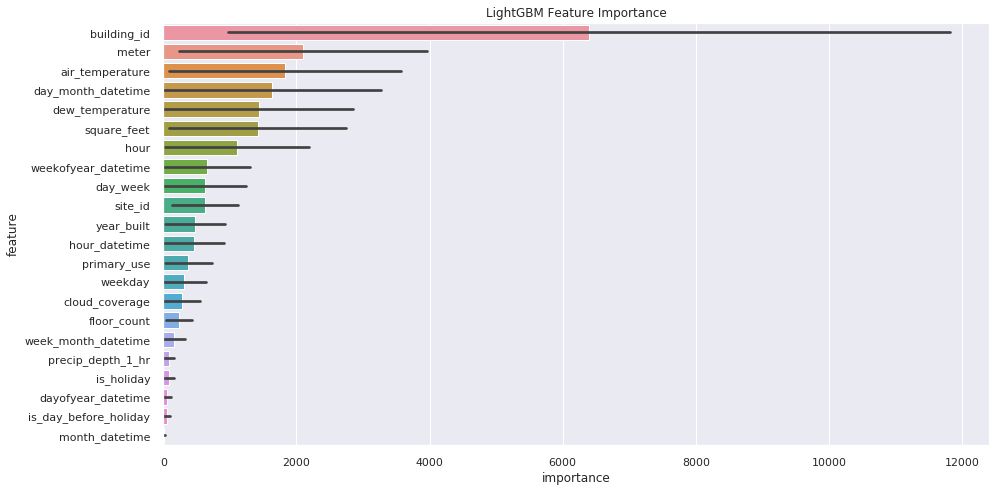

In [30]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [31]:
del X_train, y_train, X_half_1, X_half_2, y_half_1, y_half_2, d_half_1, d_half_2, watchlist_1, watchlist_2, df_fimp_1, df_fimp_2, df_fimp
gc.collect()

6095

In [32]:
df_test = pd.read_csv(path_test)
weather_test = pd.read_csv(path_weather_test)

df_test = reduce_mem_usage(df_test)
weather_test = reduce_mem_usage(weather_test)

X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 8.96 MB
Decreased by 53.0%


In [33]:
del df_test, building, weather_test
gc.collect()

254

In [34]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2

del model_half_1
gc.collect()

12

In [35]:
pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2
    
del model_half_2
gc.collect()

12

In [0]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("submission.csv", index=False)

In [0]:
submission.to_csv('~/.kaggle/submission.csv', index=False)

In [41]:
!ls ~/.kaggle

building_metadata.csv  sample_submission.csv  test.csv	 weather_test.csv
kaggle.json	       submission.csv	      train.csv  weather_train.csv


In [0]:
from IPython.display import Javascript
js_download = """
var csv = '%s';

var filename = 'submission_1.csv';
var blob = new Blob([csv], { type: 'text/csv;charset=utf-8;' });
if (navigator.msSaveBlob) { // IE 10+
    navigator.msSaveBlob(blob, filename);
} else {
    var link = document.createElement("a");
    if (link.download !== undefined) { // feature detection
        // Browsers that support HTML5 download attribute
        var url = URL.createObjectURL(blob);
        link.setAttribute("href", url);
        link.setAttribute("download", filename);
        link.style.visibility = 'hidden';
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
    }
}
""" % submission.to_csv(index=False).replace('\n','\\n').replace("'","\'")

Javascript(js_download)

In [50]:
!kaggle competitions submit ashrae-energy-prediction -f ~/.kaggle/submission.csv -m "First Submission"

100% 1.05G/1.05G [00:29<00:00, 38.9MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III